# Magnetic field interpolation through GP (sklearn)

From a 100 three-dimensional points dataset, a Gaussian Process Regressor is trained 100 times (each time with $i$ points, $i\in[1,100]$). Then the performances are plotted and a .gif shows the evolution of the error and the confidence.

In [22]:
!rm -r MagneticFieldModeling
!git clone https://github.com/nicolagulmini/MagneticFieldModeling

from MagneticFieldModeling.GP_utils import GaussianProcessRegressionUtils

# import the useful libraries

import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io # for matlab (.mat) files parsing
from mpl_toolkits import mplot3d # to plot 3D points
import time

# for the model
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

Cloning into 'MagneticFieldModeling'...
remote: Enumerating objects: 125, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (112/112), done.
remote: Total 125 (delta 41), reused 50 (delta 8), pack-reused 0
Receiving objects: 100% (125/125), 28.06 MiB | 27.08 MiB/s, done.
Resolving deltas: 100% (41/41), done.


In [2]:
mat = scipy.io.loadmat('./MagneticFieldModeling/simulated_data/fluxes_biot_5_cube5cm.mat')

In [3]:
PP_test_grd = mat['PP_test_grd']
n = mat['fluxes_biot_grd'].shape[0]
val_first_coil = np.array([np.array([el[0][0], el[1][0], el[2][0]]) for el in mat['fluxes_biot_grd']])

x_validation_positions, y_validation_positions, z_validation_positions = [PP_test_grd[i] for i in range(3)]
X_val = np.array([np.array([x_validation_positions[i], y_validation_positions[i], z_validation_positions[i]]) for i in range(n)])

In [ ]:
# load the dataset
i = 100

mat = scipy.io.loadmat("./MagneticFieldModeling/simulated_data/random_training/fluxes_biot_"+str(i)+"_cube5cm.mat")
Y, X = mat['fluxes_biot_rnd'], mat['PP_test_rnd']
Y = np.array([np.array([el[0][0], el[1][0], el[2][0]]) for el in Y])
X = np.transpose(X)

norm_den = np.mean(np.abs(val_first_coil.reshape(-1)))

nmaes = []
nrmses = []
r_2s = []
std_devs = []
nmaes_points_for_plot = []
times = []
params = []
prev_length_scale = 1.0 # to initialize with the same param

for i in range(1, len(X)):
    rbf_kernel = RBF(prev_length_scale)
    regressor = GaussianProcessRegressor(kernel=rbf_kernel, 
                                    alpha=1e-10, 
                                    optimizer='fmin_l_bfgs_b', 
                                    #n_restarts_optimizer=10, 
                                    normalize_y=False, 
                                    copy_X_train=False, 
                                    random_state=None)
    start = time.time()
    regressor.fit(X[:i], Y[:i])
    end = time.time()
    times.append(end-start)
    prev_length_scale = regressor.kernel_.length_scale
    params.append(prev_length_scale)

    nmaes.append(mean_absolute_error(regressor.predict(X_val), val_first_coil)/ norm_den * 100)
    nrmses.append(mean_squared_error(regressor.predict(X_val), val_first_coil, squared=False)/ norm_den * 100)
    r_2s.append(regressor.score(X_val, val_first_coil))

    predicted_val_mean, associated_std_dev = regressor.predict(X_val, return_std=True)
    std_devs.append(associated_std_dev / (max(associated_std_dev) - min(associated_std_dev)))

    nMAE_points = []
    for i in range(len(X_val)):
        nMAE_points.append(mean_absolute_error(regressor.predict(X_val[i].reshape((1, 3))).reshape(-1), val_first_coil[i])/norm_den*100)
    nmaes_points_for_plot.append(nMAE_points)

In [80]:
mean_time_over_20_simulations = [0.00218739, 0.00216492, 0.00287946, 0.00199901, 0.00202624, 0.00194206,
 0.00212864, 0.002085,   0.0020058,  0.01579307, 0.00785521, 0.00988486,
 0.01745839, 0.0126802,  0.00569638, 0.009055,   0.01114353, 0.00794293,
 0.00672135, 0.00936482, 0.00832978, 0.00758434, 0.00718468, 0.00585642,
 0.00620823, 0.00627455, 0.00782451, 0.0104997,  0.00632161, 0.01175485,
 0.00789205, 0.00865996, 0.01083329, 0.00885005, 0.00771255, 0.00867694,
 0.01089865, 0.00915869, 0.01121229, 0.01513293, 0.00977957, 0.01945927,
 0.03227303, 0.01521668, 0.02563037, 0.01835777, 0.01117482, 0.01593736,
 0.05451105, 0.02708559, 0.00976561, 0.00886327, 0.02396297, 0.01706612,
 0.04227113, 0.01812461, 0.01239611, 0.00839258, 0.05946626, 0.02714876,
 0.01452837, 0.02307663, 0.03094457, 0.04688364, 0.02326257, 0.02324333,
 0.02616709, 0.01182228, 0.02986137, 0.02201158, 0.02511452, 0.02179872,
 0.0173231,  0.06678895, 0.01067507, 0.04542498, 0.03146503, 0.08404843,
 0.09908205, 0.02049973, 0.11372679, 0.09082874, 0.02376177, 0.03805757,
 0.07282929, 0.03117469, 0.02088145, 0.02492336, 0.06000429, 0.03197881,
 0.07100294, 0.03149658, 0.03364625, 0.03438208, 0.03246365, 0.03036636,
 0.03292111, 0.01449735, 0.04121628]

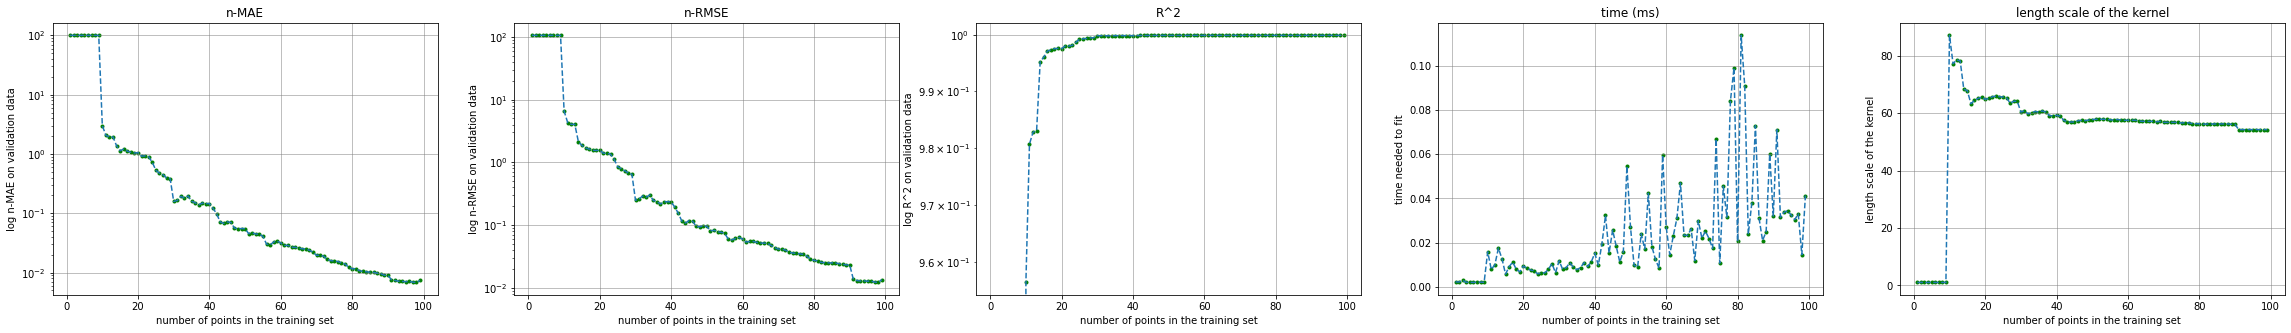

In [82]:
fig, axs = plt.subplots(1, 5, figsize=(40,5))

axs[0].set_yscale('log')
axs[0].set_title('n-MAE')
axs[0].scatter(range(1,len(X)), nmaes, color='green', marker='.')
axs[0].set_xlabel('number of points in the training set')
axs[0].set_ylabel('log n-MAE on validation data')
axs[0].plot(range(1,len(X)), nmaes, ls='--')
axs[0].grid(color='grey', linewidth=.5)

axs[1].set_yscale('log')
axs[1].set_title('n-RMSE')
axs[1].scatter(range(1,len(X)), nrmses, color='green', marker='.')
axs[1].set_xlabel('number of points in the training set')
axs[1].set_ylabel('log n-RMSE on validation data')
axs[1].plot(range(1,len(X)), nrmses, ls='--')
axs[1].grid(color='grey', linewidth=.5)

axs[2].set_yscale('log')
axs[2].set_title('R^2')
axs[2].scatter(range(1,len(X)), r_2s, color='green', marker='.')
axs[2].set_xlabel('number of points in the training set')
axs[2].set_ylabel('log R^2 on validation data')
axs[2].plot(range(1,len(X)), r_2s, ls='--')
axs[2].grid(color='grey', linewidth=.5)

#axs[2].set_yscale('log')
axs[3].set_title('time (ms)')
axs[3].scatter(range(1,len(X)), mean_time_over_20_simulations, color='green', marker='.')
axs[3].set_xlabel('number of points in the training set')
axs[3].set_ylabel('time needed to fit')
axs[3].plot(range(1,len(X)), mean_time_over_20_simulations, ls='--')
axs[3].grid(color='grey', linewidth=.5)

axs[4].set_title('length scale of the kernel')
axs[4].scatter(range(1,len(X)), params, color='green', marker='.')
axs[4].set_xlabel('number of points in the training set')
axs[4].set_ylabel('length scale of the kernel')
axs[4].plot(range(1,len(X)), params, ls='--')
axs[4].grid(color='grey', linewidth=.5)

plt.savefig('comparison metrics training points.png')

In [13]:
# pay attention to the memory

for i in range(10, len(std_devs)):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    plt.title("nMAE of the predictions (size means undertainty)")
    p = ax.scatter3D(x_validation_positions, y_validation_positions, z_validation_positions, c=nmaes_points_for_plot[i], cmap='coolwarm', alpha=1., marker='o', s=std_devs[i]*400)
    ax.set_xlabel('x (mm)')
    ax.set_ylabel('y (mm)')
    ax.set_zlabel('z (mm)')
    fig.colorbar(p, ax=ax)
    fig.savefig(str(i)+".png")
    plt.close()

In [14]:
# to produce the .gif

import imageio
filenames = ["./"+str(i)+".png" for i in range(10, len(std_devs))]
with imageio.get_writer('./movie.gif', mode='I') as writer:      
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)